In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

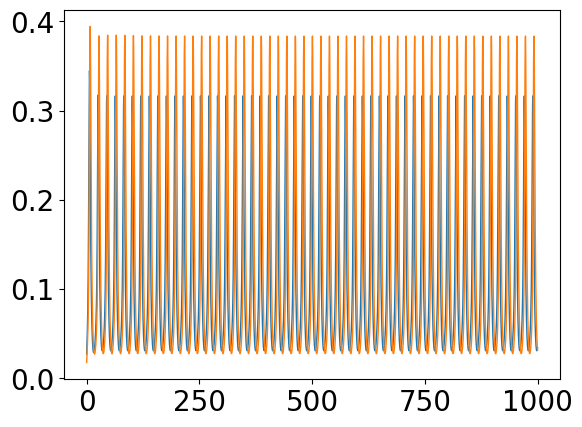

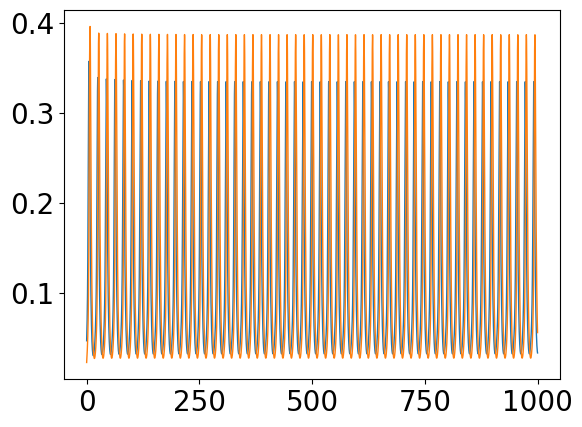

In [3]:
data = dict()
p_names = ["A", "B", "C", "D", "E", "F"]
coords = [[1., 1., "A"], [1.7, 2., "B"], [3., 1., "C"], [4., 2., "D"], [1., 0., "E"],[1.7, 0.6, "F"]]
coupling_array = [0.2, 0.6, 1.0, 1.4, 1.8, 2.2]
delay_array = [0., 4.75, 9.5, 14.25, 19.0]

cmats = []
cmats.append(np.array( [[0., 0.], [1., 0.]] ))
cmats.append(np.array( [[0., 1.], [1., 0.]] ))

for i in range(len(p_names)):
    p = p_names[i]
    data[p] = dict()
    data[p]["coordinates"] = coords[i]
    if i in [0,1,2,3]:
        data[p]["target_period"] = 15.
    elif i in [4,5]:
        data[p]["target_period"] = 19.
    data[p]["control"] = [[[None for x in range(len(coupling_array))] for y in range(len(delay_array))] for z in range(len(cmats)) ]
    data[p]["state"] = [[[None for x in range(len(coupling_array))] for y in range(len(delay_array))] for z in range(len(cmats)) ]
    #if i == 3:
    #    data[p]["w2"] = w2_array * 0.1

N = 2
delay = 10.

for ci in range(len(cmats)):
    for pi in range(len(p_names)):

        if pi != 0:
            continue

        model = WCModel(Cmat=cmats[ci], Dmat=delay*cmats[ci])

        dt = model.params['dt']
        model.params['duration'] = 1. * 1000 # Simulation time, ms
        model.params.exc_ext = data[p_names[pi]]["coordinates"][0]
        model.params.exc_inh = data[p_names[pi]]["coordinates"][1]

        model.run()

        for n in range(N):
            plt.plot(model.t, model.exc[n,:])

        plt.show()

In [4]:
for i in range(len(p_names)):

    if i in [0,1,2,3]:
        continue
    p = p_names[i]
    data[p] = dict()
    data[p]["coordinates"] = coords[i]
    data[p]["target_period"] = 19.
    data[p]["control"] = [[[None for x in range(len(coupling_array))] for y in range(len(delay_array))] for z in range(len(cmats)) ]
    data[p]["state"] = [[[None for x in range(len(coupling_array))] for y in range(len(delay_array))] for z in range(len(cmats)) ]
    #if i == 3:
    #    data[p]["w2"] = w2_array * 0.1

In [5]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

it = 400
maxstr = 5

pr = np.arange(0,1001,20)
dir = "images_2n_wc"
testd = 1000.
w2 = 1e-4

In [7]:
for i in range(len(cmats)):
    print("cmat i = ", i)

    if i == 1: continue

    for pi in range(len(p_names)):

        p = data[p_names[pi]]["coordinates"]
        print("pind = ", pi, p_names[pi], p)

        if pi not in [5]: continue

        for di in range(len(delay_array)):

            for ci in range(len(coupling_array)):

                #if [di, ci] != [4,5]: continue

                print("----------------------", di, ci)

                target_period = data[p_names[pi]]["target_period"]

                dmat = delay_array[di] * cmats[i] * 20. # multiply with signal V
                model = WCModel(Cmat=cmats[i], Dmat=dmat)
                nmaxdelay = model.getMaxDelay()
                print("target period, max delay = ", target_period, nmaxdelay)
            
                model.params.duration = testd
                test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
                model.params["exc_ext"] = test_input + p[0]
                model.params["inh_ext"] = test_input + p[1]

                if i== 1 and pi in [4,5]:
                    sine_input = np.vstack( ([test_input]*2) )[np.newaxis,:,:]
                    sine_input = np.vstack( ([sine_input]*N))
                    stim_period = 19
                    sine_input[0,0,:int(stim_period/dt)] = 3. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)
                    sine_input[1,0,:int(stim_period/dt)] = -3. * np.sin(2.*np.pi*np.arange(0,stim_period,dt)/stim_period)
                    model.params["exc_ext"] = sine_input[:,0,:] + p[0]

                model.params.K_gl = coupling_array[ci]
                model.run()

                einit = np.zeros((N, nmaxdelay+1))
                iinit = np.zeros((N, nmaxdelay+1))
                for n in range(N):
                    model.params.exc_init = einit
                    model.params.inh_init = iinit

                shiftn = [0,0]
                for n in range(N):
                    if shiftn[n] == 0:
                        einit[n,:] = model.exc[n,-nmaxdelay-1:]
                        iinit[n,:] = model.inh[n,-nmaxdelay-1:]
                    else:
                        einit[n,:] = model.exc[n,-nmaxdelay-1-shiftn[n]:-shiftn[n]]
                        iinit[n,:] = model.inh[n,-nmaxdelay-1-shiftn[n]:-shiftn[n]]

                if pi in [0,1,2,3]:
                    duration = 100.
                else:
                    duration = 300.

                zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
                zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
                zero_control = np.vstack( ([zero_input]*N))
                    
                model.params.duration = duration
                model.params["exc_ext"] = zero_control[:,0,:] + p[0]
                model.params["inh_ext"] = zero_control[:,0,:] + p[1]
                model.params["exc_init"] = einit
                model.params["inh_init"] = iinit
                model.run()

                if False:
                    plt.plot(model.t, model.exc[0,:])
                    plt.plot(model.t, model.exc[1,:])
                    plt.show()

                i00 = 0
                int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)     
                while int0 > 3*target_period/dt:
                    i00 += 1
                    int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)
                i00 = 0
                intc0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)     
                while intc0 > 1*target_period/dt:
                    i00 += 1
                    intc0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)

                model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(intc0, -int(80/model.params.dt)), cost_matrix=costmat, control_matrix=controlmat)
                model_controlled.compute_step_per_nv = True
                model_controlled.weights["w_p"] = 0.
                model_controlled.weights["w_2"] = w2
                if pi in [4]:
                    model_controlled.weights["w_2"] = w2 * 1. * 1e5
                elif pi in [5]:
                    model_controlled.weights["w_2"] = w2 * 1. * 1e6

                if pi in [0,1,2,3]:
                    model_controlled.weights["w_f_sync"] = 1.
                else:
                    model_controlled.weights["w_cc1"] = 1.

                model_controlled.maximum_control_strength = maxstr

                if True:
                    if type(data[p_names[pi]]["control"][i][di][ci]) != type(None):
                        if np.amax(data[p_names[pi]]["control"][i][di][ci][:,:,:intc0]) == 0.:
                            model_controlled.control = data[p_names[pi]]["control"][i][di][ci].copy()
                            model_controlled.update_input()

                if False:
                    model_controlled.optimize(0)
                    stim_period = 18
                    periods = 5
                    sine_input[0,0,:int(periods*stim_period/dt)] =  0.5 * (1. + np.sin(2.*np.pi*np.arange(0,periods*stim_period,dt)/stim_period) )
                    sine_input[1,0,:int(periods*stim_period/dt)] = 0.5 * (1. + np.sin(2.*np.pi*np.arange(0,periods*stim_period,dt)/stim_period) )
                    model_controlled.control[0,:,intc0:intc0+1000] = sine_input[0,:,:1000]
                    model_controlled.control[1,:,intc0:intc0+1000] = sine_input[1,:,:1000]
                    #model_controlled.control[0,:,:] = 0.
                    #model_controlled.control[1,:,:] = 0.
                    model_controlled.update_input()

                model_controlled.optimize(it)
                data[p_names[pi]]["control"][i][di][ci] = model_controlled.control.copy()
                data[p_names[pi]]["state"][i][di][ci] = model_controlled.get_xs()

                if False:
                    plt.plot(model_controlled.model.t, model_controlled.get_xs()[0,0,1:])
                    plt.plot(model_controlled.model.t, model_controlled.get_xs()[1,0,1:])
                    plt.show()

                    plt.plot(model_controlled.model.t, model_controlled.control[0,0,1:])
                    plt.plot(model_controlled.model.t, model_controlled.control[1,0,1:])
                    plt.show()

            with open('osc_2n_wc.pickle', 'wb') as f:
                pickle.dump(data, f)

cmat i =  0
pind =  0 A [1.0, 1.0, 'A']
pind =  1 B [1.7, 2.0, 'B']
pind =  2 C [3.0, 1.0, 'C']
pind =  3 D [4.0, 2.0, 'D']
pind =  4 E [1.0, 0.0, 'E']
pind =  5 F [1.7, 0.6, 'F']
---------------------- 0 0
target period, max delay =  19.0 0
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -3367.232378057333
Cost in iteration 20: -9471.35641524032
Cost in iteration 40: -9501.91957446369
Cost in iteration 60: -9511.774667372278
Cost in iteration 80: -9519.125839409571
Cost in iteration 100: -9525.289857569238
Cost in iteration 120: -9538.370860438032
Cost in iteration 140: -9547.306099676618
Cost in iteration 160: -9556.600458880632
Cost in iteration 180: -9563.728251967734
Cost in iteration 200: -9569.879041633667
Cost in iteration 220: -9576.912957222656
Cost in iteration 240: -9581.007567481269
Cost in iteration 260: -9585.346455258665
Cost in iteration 280: -9588.831667849587
Cost in iteration 300: -9591.360873877571
Cost

In [8]:
for pi in range(len(p_names)):

    if pi not in [4,5]: continue

    if pi in [0,1,2,3]:
        duration = 100.
    else:
        duration = 300.

    print(p_names[pi])

    title = "WC 2N-I, "
    if pi in [0,1]: title = title + r"down $\rightarrow$ osc"
    elif pi in [2,3]: title = title + r"up $\rightarrow$ osc"
    elif pi in [4,5]: title = title + r"sync osc"
    title = title + ", point (" + str(p_names[pi]) + ")"

    for di in range(len(delay_array)):
        
        print("delay ", di)
        filename = os.path.join(dir, "2N-I_" + p_names[pi] + "_delay_" + str(di) + ".png")
        if pi in [0,1,2,3]:
            plot_coupling(data[p_names[pi]], duration, dt, di, 0, filename, title, zoom=False)
        elif pi in [4,5]:
            plot_coupling_nodes(data[p_names[pi]], duration, dt, di, 0, filename, title)

    for ci in range(len(coupling_array)):    
        print("coupling ", ci)
        filename = os.path.join(dir, "2N-I_" + p_names[pi] + "_coupling_" + str(ci) + ".png")
        if pi in [0,1,2,3]:
            plot_delay(data[p_names[pi]], duration, dt, ci, 0, filename, title, zoom=False)
        elif pi in [4,5]:
            plot_delay_nodes(data[p_names[pi]], duration, dt, ci, 0, filename, title)


E
delay  0


NameError: name 'plot_coupling_nodes' is not defined

In [9]:
for pi in range(len(p_names)):

    if pi not in [4,5]: continue

    if pi in [0,1,2,3]:
        duration = 100.
    else:
        duration = 300.

    print(p_names[pi])

    title = "WC 2N-II, "
    if pi in [0,1]: title = title + r"down $\rightarrow$ osc"
    elif pi in [2,3]: title = title + r"up $\rightarrow$ osc"
    elif pi in [4,5]: title = title + r"sync osc"
    title = title + ", point (" + str(p_names[pi]) + ")"

    for di in range(len(delay_array)):
        
        print("delay ", di)
        filename = os.path.join(dir, "2N-II_" + p_names[pi] + "_delay_" + str(di) + ".png")
        if pi in [0,1,2,3]:
            plot_coupling(data[p_names[pi]], duration, dt, di, 1, filename, title, zoom=False)
        elif pi in [4,5]:
            plot_coupling_nodes(data[p_names[pi]], duration, dt, di, 1, filename, title)

    for ci in range(len(coupling_array)):    
        print("coupling ", ci)
        filename = os.path.join(dir, "2N-II_" + p_names[pi] + "_coupling_" + str(ci) + ".png")
        if pi in [0,1,2,3]:
            plot_delay(data[p_names[pi]], duration, dt, ci, 1, filename, title, zoom=False)
        elif pi in [4,5]:
            plot_delay_nodes(data[p_names[pi]], duration, dt, ci, 1, filename, title)

E
delay  0


NameError: name 'plot_coupling_nodes' is not defined

In [ ]:
cmap = plt.cm.get_cmap("jet")

def plot_delay(data, dur, dt, ci, i, filename, title, zoom=False):
    if zoom:
        fig, ax = plt.subplots(2,4, figsize=(24,10), gridspec_kw={'width_ratios': [3, 2, 3, 2]}, sharex="col", sharey="row")
        ind0, ind1 = 0,2
    else:
        fig, ax = plt.subplots(2,2, figsize=(16,10), sharex="col", sharey="row")
        ind0, ind1 = 0,1
    time_array = np.arange(0, dur+dt, dt)

    for di in range(len(delay_array)):
        if data["state"][i][di][ci] is None:
            continue
        
        c = cmap(di/(len(delay_array)-1))

        ax[0, ind0].plot(time_array, data["state"][i][di][ci][0,0,:], color=c, label=r"$\tau = $" + str(delay_array[di]))
        ax[1, ind0].plot(time_array, data["control"][i][di][ci][0,0,:], color=c)
        ax[0, ind1].plot(time_array, data["state"][i][di][ci][1,0,:], color=c)
        ax[1, ind1].plot(time_array, data["control"][i][di][ci][1,0,:], color=c)

        if zoom:
            mins = scipy.signal.find_peaks(-data["state"][i][di][ci][0,0,:])[0]
            i0, i1 = mins[-3]-10, mins[-2]+10

            time_osc = np.linspace(0, (i1-i0)*dt, i1-i0, endpoint=True)
            #print(i1 - i0)

            ax[0, 1].plot(time_osc, data["state"][i][di][ci][0,0,i0:i1], color=c)
            ax[1, 1].plot(time_osc, data["control"][i][di][ci][0,0,i0:i1], color=c)
            ax[0, 3].plot(time_osc, data["state"][i][di][ci][1,0,i0:i1], color=c)
            ax[1, 3].plot(time_osc, data["control"][i][di][ci][1,0,i0:i1], color=c)

    ax[0,ind0].legend(loc="upper left", labelspacing = 0.3)

    ax[0,ind0].set_xlim(0, duration)
    ax[1,ind0].set_xlim(0, duration)
    ax[0,ind1].set_xlim(0, duration)
    ax[1,ind1].set_xlim(0, duration)

    ax[1,ind0].set_xlabel("Time")
    ax[1,ind1].set_xlabel("Time")
    ax[0,ind0].set_ylabel(r"Activity")
    ax[1,ind0].set_ylabel(r"Control")

    if zoom:
        ax[0,1].set_xlim(0, (i1-i0)*dt)
        ax[1,1].set_xlim(0, (i1-i0)*dt)
        ax[0,3].set_xlim(0, (i1-i0)*dt)
        ax[1,3].set_xlim(0, (i1-i0)*dt)

    plt.subplots_adjust(
                    wspace=0.1,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    title = "2N-I"
    if i == 1:
        title = title + "I"
    title = title + r", $c_{gl} = $" + str(coupling_array[ci])
    fig.suptitle(title)

    ax[0,ind0].set_title("n=0")
    ax[0,ind1].set_title("n=1")

    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.show()
    return

def plot_coupling(data, dur, dt, di, i, filename, title, zoom=False):
    if zoom:
        fig, ax = plt.subplots(2,4, figsize=(24,10), gridspec_kw={'width_ratios': [3, 2, 3, 2]}, sharex="col", sharey="row")
        ind0, ind1 = 0,2
    else:
        fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row")
        ind0, ind1 = 0,1
    time_array = np.arange(0, dur+dt, dt)

    for ci in range(len(coupling_array)):

        if data["state"][i][di][ci] is None:
            continue

        c = cmap(ci/(len(coupling_array)-1))

        ax[0, ind0].plot(time_array, data["state"][i][di][ci][0,0,:], color=c, label=r"$c_{gl} = $" + str(coupling_array[ci]))
        ax[1, ind0].plot(time_array, data["control"][i][di][ci][0,0,:], color=c)
        ax[0, ind1].plot(time_array, data["state"][i][di][ci][1,0,:], color=c)
        ax[1, ind1].plot(time_array, data["control"][i][di][ci][1,0,:], color=c)

        if zoom:
            mins = scipy.signal.find_peaks(-data["state"][i][di][ci][0,0,:])[0]
            i0, i1 = mins[-3]-10, mins[-2]+10

            time_osc = np.linspace(0, (i1-i0)*dt, i1-i0, endpoint=True)
            #print(i1 - i0)

            ax[0, 1].plot(time_osc, data["state"][i][di][ci][0,0,i0:i1], color=c)
            ax[1, 1].plot(time_osc, data["control"][i][di][ci][0,0,i0:i1], color=c)
            ax[0, 3].plot(time_osc, data["state"][i][di][ci][1,0,i0:i1], color=c)
            ax[1, 3].plot(time_osc, data["control"][i][di][ci][1,0,i0:i1], color=c)

    ax[0,ind0].legend(loc="upper left", labelspacing = 0.3)

    ax[0,ind0].set_xlim(0, duration)
    ax[1,ind0].set_xlim(0, duration)
    ax[0,ind1].set_xlim(0, duration)
    ax[1,ind1].set_xlim(0, duration)

    ax[1,ind0].set_xlabel("Time")
    ax[1,ind1].set_xlabel("Time")
    ax[0,ind0].set_ylabel("Activity")
    ax[1,ind0].set_ylabel("Control")

    if zoom:
        ax[0,1].set_xlim(0, (i1-i0)*dt)
        ax[1,1].set_xlim(0, (i1-i0)*dt)
        ax[0,3].set_xlim(0, (i1-i0)*dt)
        ax[1,3].set_xlim(0, (i1-i0)*dt)

    plt.subplots_adjust(
                    wspace=0.1,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    title = "2N-I"
    if i == 1:
        title = title + "I"
    title = title + r", $\tau = $" + str(delay_array[di])
    fig.suptitle(title)

    ax[0,ind0].set_title("n=0")
    ax[0,ind1].set_title("n=1")

    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.show()
    return

def plot_coupling_nodes(data, dur, dt, di, i, filename, title):
    fig, ax = plt.subplots(2,len(coupling_array), figsize=(20,8), sharex=True, sharey="row")
    time_array = np.arange(0, dur+dt, dt)

    for ci in range(len(coupling_array)):
        if data["state"][i][di][ci] is None:
            continue

        c = cmap(ci/(len(coupling_array)-1))

        ax[0, ci].set_title(r"$c_{gl} = $" + str(coupling_array[ci]))

        ax[0,ci].plot(time_array, data["state"][i][di][ci][0,0,:], color=c, label="N0")
        ax[0,ci].plot(time_array, data["state"][i][di][ci][1,0,:], color=c, linestyle=":", label="N1")
        ax[1,ci].plot(time_array, data["control"][i][di][ci][0,0,:], color=c)
        ax[1,ci].plot(time_array, data["control"][i][di][ci][1,0,:], color=c, linestyle=":")

        ax[1,ci].set_xlabel("Time")

    ax[0,0].legend(loc="upper left", labelspacing = 0.1, handletextpad=0.2, handlelength=2, borderaxespad=0.3, borderpad=0.2)
    ax[0,0].set_xlim(0, duration)
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    plt.subplots_adjust( wspace=0.2, hspace=0.1)
    fig.align_ylabels([ax[:,0]])
    fig.suptitle(title + r", delay $\tau = $" + str(delay_array[di]))

    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.show()
    return

def plot_delay_nodes(data, dur, dt, ci, i, filename, title):
    fig, ax = plt.subplots(2,len(delay_array), figsize=(20,8), sharex=True, sharey="row")
    time_array = np.arange(0, dur+dt, dt)

    for di in range(len(delay_array)):
        if data["state"][i][di][ci] is None:
            continue

        c = cmap(di/(len(delay_array)-1))

        ax[0,di].set_title(r"$\tau = $" + str(delay_array[di]))

        ax[0,di].plot(time_array, data["state"][i][di][ci][0,0,:], color=c, label="N0")
        ax[0,di].plot(time_array, data["state"][i][di][ci][1,0,:], color=c, linestyle=":", label="N1")
        ax[1,di].plot(time_array, data["control"][i][di][ci][0,0,:], color=c)
        ax[1,di].plot(time_array, data["control"][i][di][ci][1,0,:], color=c, linestyle=":")

        ax[1,di].set_xlabel("Time")

    ax[0,0].legend(loc="upper left", labelspacing = 0.1, handletextpad=0.2, handlelength=2, borderaxespad=0.3, borderpad=0.2)
    ax[0,0].set_xlim(0, duration)
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    plt.subplots_adjust( wspace=0.2, hspace=0.1)
    fig.align_ylabels([ax[:,0]])
    fig.suptitle(title + r", coupling strength $c_{gl} = $" + str(coupling_array[ci]))

    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.show()
    return

In [ ]:
with open('osc_2n_wc.pickle', 'wb') as f:
    pickle.dump(data, f)

In [6]:
with open('osc_2n_wc.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['A', 'B', 'C', 'D', 'E', 'F'])
